In [10]:
# Access some helpful tools
import tools
import random

In [11]:
# Represent an atom using x,y coordinates, starting at the origin.
# For argument's sake say the length scale is just arbitrary/scaled units of '1'.
atom = [0, 0]

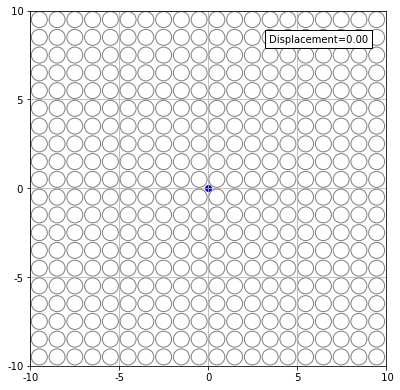

In [12]:
# Display the position of the atom
tools.display_atom(atom)

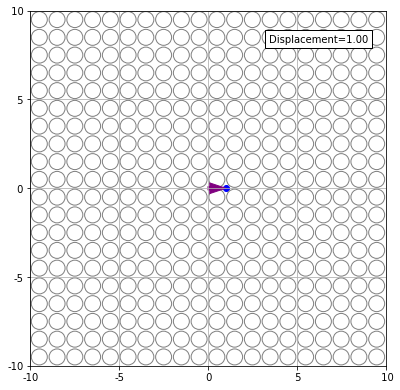

In [13]:
# Make the atom 'walk' around the square lattice by randomly jumping

atom = [0, 0] 

# Define moving left or right randomly
atom[0] = atom[0] + random.randint(-1, 1)

# Define moving up or down randomly
atom[1] = atom[1] + random.randint(-1, 1)

tools.display_atom(atom)

In [14]:
def jump(atom):
    """Make the atom 'walk' around the square lattice by randomly jumping."""

    original_x, original_y = atom

    directions = ["Up", "Down", "Left", "Right"]
    random_direction = random.choice(directions)

    if random_direction == "Up":
        new_x = original_x
        new_y = original_y + 1

    if random_direction == "Down":
        new_x = original_x
        new_y = original_y - 1

    if random_direction == "Left":
        new_x = original_x - 1
        new_y = original_y

    if random_direction == "Right":
        new_x = original_x + 1
        new_y = original_y

    updated_atom = [new_x, new_y]

    return updated_atom

In [15]:
def simulate_atom(m_steps):

    atom = [0, 0]
    atom_history = []
    # disp_history = [displacement(atom)]

    for step in range(m_steps):
        atom_history.append(atom)
        updated_atom = jump(atom)
        atom = updated_atom

    atom_history.append(atom)

    return atom_history

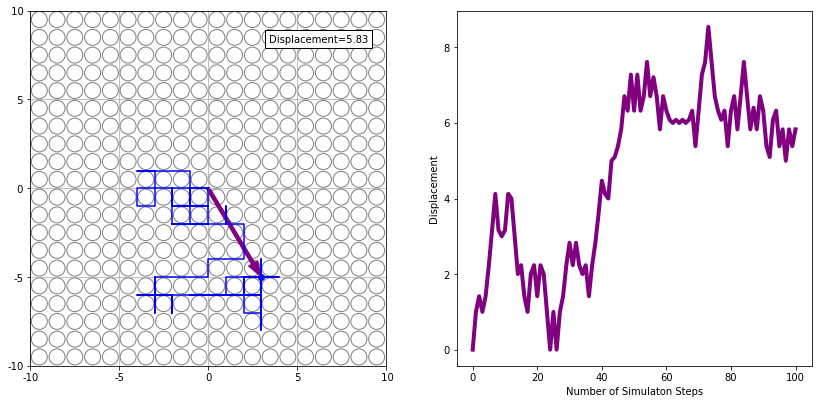

In [16]:
atom_history = simulate_atom(m_steps=100)
tools.display_atom(atom_history, show_displacement=True)

In [17]:
def simulate_atoms(n_atoms, m_steps):

    atom_histories = []

    for n in range(n_atoms):
        atom = [0, 0]
        atom_history = simulate_atom(m_steps)
        atom_histories.append(atom_history)

    return atom_histories

TypeError: 'int' object is not iterable

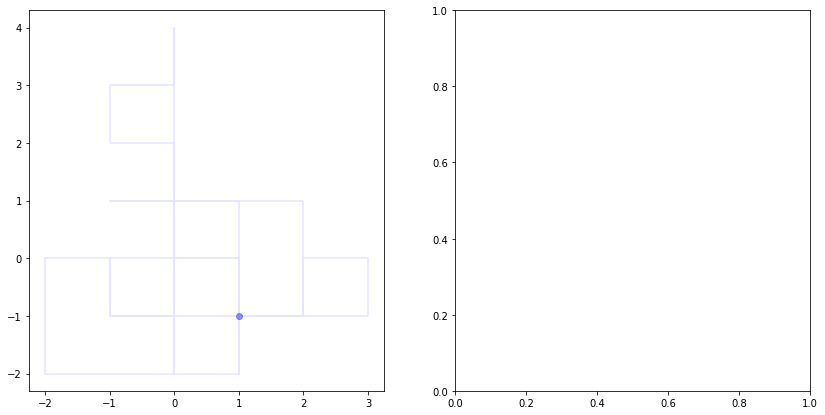

In [18]:
atom_histories = simulate_atoms(n_atoms=300, m_steps=50)
tools.display_atoms(atom_histories)

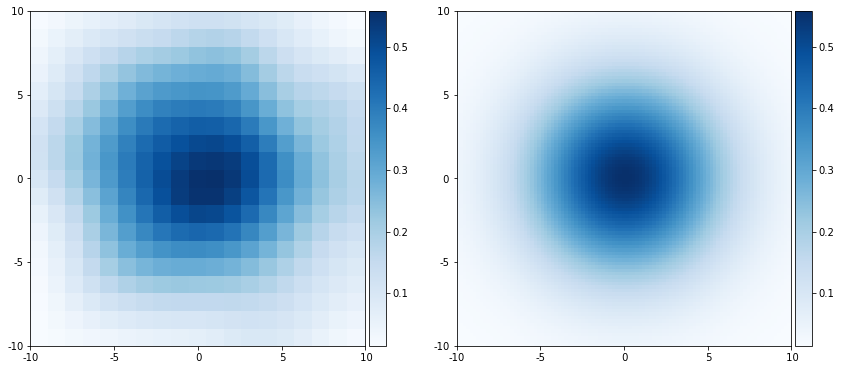

In [ ]:
tools.display_probability(atom_histories, show_gaussian=True)